## Hybrid model evaluation

In [7]:
import pandas as pd
import torch
import pandas as pd
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from peft import PeftModel
from sklearn.metrics import classification_report
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

c:\Users\shiva\miniconda3\envs\finetune\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
val_test_2009_data=pd.read_csv("val_data_pred.csv")

In [4]:
val_test_2009_data.head(1)

,Unnamed: 0,instruction,input,output,prompt,predicted_label
0,0,"Classify the type of adverse event as Death, I...",A patient reported an incident involving the A...,Injury,"Classify the type of adverse event as Death, I...",Injury


In [6]:

true_labels = val_test_2009_data["output"].tolist()

### MOdel load

In [10]:
from torch.nn.functional import softmax

# Define your label set in the exact form the model outputs
label_list = ["Death", "Injury", "Device Malfunction"]

In [8]:
# %% [Load Quantized Base Model + Tokenizer]
model_name = "microsoft/Phi-3-mini-4k-instruct"
compute_dtype = torch.float16

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=False,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=compute_dtype,
)

base_model = AutoModelForCausalLM.from_pretrained(
    model_name,
    trust_remote_code=True,
    device_map="auto",
    quantization_config=bnb_config,
)
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token

`flash-attention` package not found, consider installing for better performance: No module named 'flash_attn'.
Current `flash-attention` does not support `window_size`. Either upgrade or use `attn_implementation='eager'`.
Loading checkpoint shards: 100%|██████████| 2/2 [00:08<00:00,  4.45s/it]


In [9]:
model = PeftModel.from_pretrained(base_model, "trained-model")
model.eval()
model.config.use_cache = False  # <- THIS IS CRUCIAL

In [11]:
preds = []
probs_list = []

for prompt in tqdm(val_test_2009_data["prompt"].tolist(), desc="Generating Predictions"):
    inputs = tokenizer(prompt, return_tensors="pt", truncation=True).to(model.device)
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=5,  # small since classification
            do_sample=False,
            use_cache=False,
            pad_token_id=tokenizer.pad_token_id,
            return_dict_in_generate=True,
            output_scores=True
        )

    # Decode full prediction
    decoded = tokenizer.decode(outputs.sequences[0], skip_special_tokens=True)
    prediction = decoded.split("Answer:")[-1].strip().split("\n")[0]
    preds.append(prediction)

    # Get token-level probabilities
    # We take the first generated token after the input context
    transition_scores = outputs.scores  # list of logits per generation step
    if transition_scores:  
        step_logits = transition_scores[0]  # first step logits
        step_probs = softmax(step_logits, dim=-1)
        label_probs = {}
        for label in label_list:
            label_token_id = tokenizer(label, add_special_tokens=False).input_ids[0]
            label_probs[label] = step_probs[0, label_token_id].item()
        probs_list.append(label_probs)
    else:
        probs_list.append({label: None for label in label_list})
    del inputs, outputs, step_logits, step_probs
    torch.cuda.empty_cache()

Generating Predictions: 100%|██████████| 159/159 [01:51<00:00,  1.42it/s]


In [14]:
len(preds),val_test_2009_data.shape

(159, (159, 6))

In [16]:
val_test_2009_data["new_pred_label"]=preds
val_test_2009_data["predicted_probability"]=probs_list

In [17]:
val_test_2009_data.to_csv("testing_2009_data.csv")

✅ Accuracy: 0.7987

📊 Classification Report:

                    precision    recall  f1-score   support

             Death     0.8444    0.8444    0.8444        45
Device Malfunction     0.8718    0.8608    0.8662        79
            Injury     0.5833    0.6000    0.5915        35

          accuracy                         0.7987       159
         macro avg     0.7665    0.7684    0.7674       159
      weighted avg     0.8006    0.7987    0.7996       159



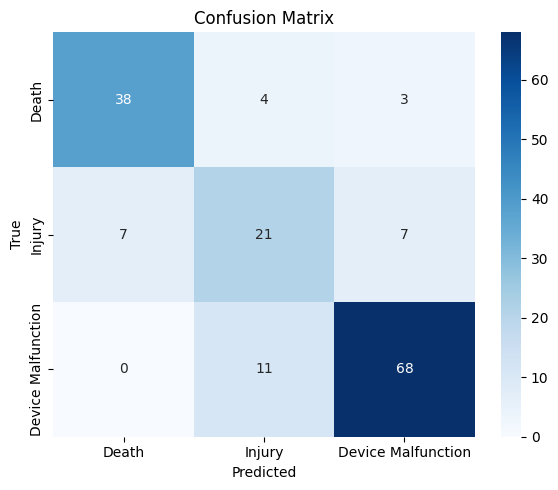

In [19]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Add predictions to DataFrame
val_test_2009_data["new_pred_label"] = preds

# Ground truth and predictions
true_labels = val_test_2009_data["output"].tolist()
pred_labels = val_test_2009_data["new_pred_label"].tolist()

# Accuracy
accuracy = accuracy_score(true_labels, pred_labels)
print(f"✅ Accuracy: {accuracy:.4f}")

# Classification report
print("\n📊 Classification Report:\n")
print(classification_report(true_labels, pred_labels, digits=4))

# Confusion Matrix
labels = ["Death", "Injury", "Device Malfunction"]
cm = confusion_matrix(true_labels, pred_labels, labels=labels)

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=labels, yticklabels=labels, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


## Implement keyword extraction 

In [ ]:
from keybert import KeyBERT
from sentence_transformers import SentenceTransformer, util
import numpy as np

# ===== Your dictionary =====
DICT_TERMS = {
    "Device Malfunction": [
        "device malfunction", "equipment malfunction", "malfunction during use",
        "device not working", "device failed", "failure during operation",
        "failure to function", "malfunction on deployment", "malfunction after use",
        "deployment failure", "incomplete deployment", "unable to deploy",
        "failed to deploy", "partial deployment", "deployment interrupted",
        "failed to lock", "locking issue", "activation failure",
        "device misfire", "delivery issue", "misalignment of device",
        "device damage", "component breakage", "handle breakage",
        "material integrity issue", "broken tip", "torn sleeve",
        "kinked sheath", "catheter kink", "component dislodged",
        "sealant exposed", "loose seal", "sealant leakage", "sealant failure",
        "balloon leak", "balloon burst", "balloon deflation",
        "unable to inflate", "leak in system", "fluid leakage",
        "device stuck", "entrapment issue", "obstructed device",
        "retained device", "unable to remove device",
        "system error", "software error", "firmware bug",
        "power failure", "battery failure", "low battery alert",
        "display malfunction", "false alarm", "incorrect reading","cuff miss",
        "quality issue", "reported difficulty", "device returned", "device behavior", 
        "device performance", "reported malfunction", "returned for analysis", 
        "proglide failure", "mechanical issue","clicking sound", "double click", "clicks on activation",
        "device click", "unexpected click", "plunger click",
        "audible click", "strange sound", "device noise", 
        "mechanical feedback","anchor failed", "footplate broken", "collagen plug issue", "plug misplacement",
        "clip misfire", "clip dislodged", "anchor not seated", "prostar failure",
        "device mispositioned", "poor seal", "incomplete closure", "deployment drift",
        "suture break", "clip snapped", "cord rupture", "VCD jammed", "advancer stuck",
        "release failure", "footing not deployed", "clip ejected", "seal not achieved","device knot",
        "deployment issue","catheter jammed","stuck device"



    ],
    "Injury": [
        "bleeding", "excessive bleeding", "control of bleeding",
        "inability to stop bleeding", "hemostasis failure", "manual compression",
        "hematoma", "hematoma formation", "site hematoma",
        "pain", "site pain", "localized pain", "post-procedure pain",
        "site discomfort", "discomfort", "local irritation",
        "infection", "site infection", "wound infection",
        "inflammatory reaction", "swelling", "redness",
        "bruising", "seroma", "delayed healing", "wound complication",
        "vessel injury", "vascular injury", "arterial injury",
        "tissue damage", "tissue necrosis", "necrosis",
        "pseudoaneurysm", "extravasation", "vascular spasm",
        "ischemia", "limb ischemia", "nerve injury", "limb numbness", "numbness",
        "hypersensitivity reaction", "allergic reaction", "skin reaction",
        "contact dermatitis", "rash", "burns","hematosis","occlusion","retroperitoneal bleed", "AV fistula", "femoral pseudoaneurysm",
    "vessel perforation", "artery dissection", "groin pain", "groin hematoma",
    "thrombus formation", "deep vein thrombosis", "vascular laceration",
    "prolonged bleeding", "puncture site complication", "arterial embolism"

    ],
    "Death": [
        "patient died", "patient death", "death reported",
        "death occurred", "fatal event", "fatal outcome",
        "loss of life", "mortality", "fatality", "lethal event",
        "procedure-related death", "unexpected death", "sudden death",
        "death following procedure", "fatal complication",
        "patient demise", "passed away", "found deceased",
        "collapsed and died", "expired", "death confirmed",
        "pronounced dead", "declared dead", "cause of death",
        "autopsy revealed", "post mortem", "post-mortem",
        "death certificate", "no signs of life", "end of life",
        "died suddenly", "died during procedure", "died after procedure","cardiac arrest during procedure", "exsanguination", "massive bleed",
    "vascular collapse", "procedure fatality", "died from complication",
    "bleed-out", "femoral rupture", "death due to AV fistula", "fatal stroke",
    "multi-organ failure", "cardiovascular collapse"

    ]
}

# ===== Models =====
bert_model = SentenceTransformer("all-MiniLM-L6-v2")
kw_model = KeyBERT(model=bert_model)

## Core logic of Keyword extraction and fine tuned model together

In [ ]:
import re, json, numpy as np, pandas as pd
from sentence_transformers import util
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
# ------------------- Config -------------------
LABELS = ["Death", "Injury", "Device Malfunction"]

# thresholds (tune on your val set)
HI_THRESH = 0.70
MARGIN_THRESH = 0.10
ALPHA_DEFAULT = 0.60    # normal hybrid
ALPHA_LOW = 0.35        # when margin small / confidence low

EVIDENCE_TOPK = 12
EVIDENCE_MIN_COS = 0.30

# Death-specific safeguards (optional but recommended)
ENFORCE_DEATH_CONFIRMATION = True
DEATH_EVID_MIN = 0.55         # min evidence to allow Death as final
DEATH_COS_MIN = 0.58          # stricter cosine gate for Death
EVIDENCE_CAP_NO_STRICT_DEATH = 0.35

# Strict death cues (exact-ish, surface forms)
DEATH_STRICT = [
    r"\bpatient (?:died|expired)\b",
    r"\bpronounced dead\b",
    r"\bdeclared dead\b",
    r"\bfound deceased\b",
    r"\bpassed away\b",
    r"\bfatal (?:event|outcome|complication)\b",
    r"\bdeath (?:occurred|reported|confirmed)\b",
    r"\bmortality\b", r"\bfatality\b"
]
# Simple negation window
NEGATION_PAT = r"(no|not|without|never|denies?|rule[sd]?\s*out)\s+(?:any\s+)?(death|died|deceased|fatal|expired)"

# ------------------- Helpers -------------------
def keybert_terms(text, top_k=15):
    kws = kw_model.extract_keywords(
        text, keyphrase_ngram_range=(1,3), stop_words='english', top_n=top_k
    )
    return [w for w,_ in kws]

def has_strict_death(text: str) -> bool:
    if re.search(NEGATION_PAT, text, flags=re.I):
        return False
    return any(re.search(pat, text, flags=re.I) for pat in DEATH_STRICT)

def parse_prob_dict(x):
    if isinstance(x, dict): 
        return x
    if isinstance(x, str):
        try:
            return json.loads(x.replace("'", '"'))
        except Exception:
            return {}
    return {}

from sentence_transformers import util
import numpy as np

def evidence_for_label(text, label):
    """
    Returns (evidence_score in [0,1], matches:list)
    matches: [{extracted_term, matched_dict_term, score}]
    """
    if label not in DICT_TERMS:
        print("coming here")
        return 0.0, []

    ext_terms = keybert_terms(text, top_k=EVIDENCE_TOPK)
    print(ext_terms)
    if not ext_terms:
        print("coming here")
        return 0.0, []

    dict_terms = DICT_TERMS[label]
    dict_emb = bert_model.encode(dict_terms, convert_to_tensor=True, normalize_embeddings=True)
    ext_emb  = bert_model.encode(ext_terms,  convert_to_tensor=True, normalize_embeddings=True)

    cos = util.cos_sim(ext_emb, dict_emb).cpu().numpy()

    matches = []
    min_cos = DEATH_COS_MIN if label == "Death" else EVIDENCE_MIN_COS

    for i, term in enumerate(ext_terms):
        j = int(cos[i].argmax())
        s = float(cos[i][j])
        print(s,"--------",term,dict_terms[j])
        if s >= min_cos:
            matches.append({
                "extracted_term": term,
                "matched_dict_term": dict_terms[j],
                "score": round(s, 3)
            })

    if not matches:
        # fallback: return top 3 best-scoring matches even if below threshold
        fallback = []
        for i, term in enumerate(ext_terms):
            j = int(cos[i].argmax())
            s = float(cos[i][j])
            fallback.append({
                "extracted_term": term,
                "matched_dict_term": dict_terms[j],
                "score": round(s, 3)
            })
        fallback = sorted(fallback, key=lambda x: x["score"], reverse=True)[:3]
        return 0.0, fallback

    # aggregate: mean of top 5 semantic scores
    top_scores = sorted([m["score"] for m in matches], reverse=True)[:5]
    avg_sem = float(np.mean(top_scores))
    evid = avg_sem

    if label == "Death":
        if has_strict_death(text):
            evid = max(evid, 0.9)
        else:
            evid = min(evid, EVIDENCE_CAP_NO_STRICT_DEATH)

    return evid, sorted(matches, key=lambda x: x["score"], reverse=True)[:5]


def clean_keyword_list(matches, topn=8, with_scores=False):
    """
    Deduplicate by matched_dict_term, keep top-N. Return a clean list of terms (or term:score).
    """
    seen, cleaned = set(), []
    for m in sorted(matches, key=lambda x: x["score"], reverse=True):
        term = m["matched_dict_term"]
        if term in seen: 
            continue
        seen.add(term)
        if with_scores:
            cleaned.append(f"{term}:{m['score']}")
        else:
            cleaned.append(term)
        if len(cleaned) >= topn:
            break
    return cleaned

def pick_final_with_death_guard(text, combined, evidence):
    cand = max(combined.items(), key=lambda x: x[1])[0]
    if not ENFORCE_DEATH_CONFIRMATION or cand != "Death":
        return cand, "hybrid_fallback"
    strict = has_strict_death(text)
    evid_ok = evidence.get("Death", 0.0) >= DEATH_EVID_MIN
    if strict and evid_ok:
        return "Death", "hybrid_fallback_confirmed_death"
    # Demote Death
    non_death = {k: v for k, v in combined.items() if k != "Death"}
    alt = max(non_death.items(), key=lambda x: x[1])[0]
    return alt, "death_demoted_insufficient_evidence"

# ------------------- Core classify -------------------
def classify_row(row):
    text = row["input"]
    prob = parse_prob_dict(row["predicted_probability"])
    # ensure all labels exist
    prob = {lab: float(prob.get(lab, 0.0)) for lab in LABELS}

    # top-2
    sorted_labs = sorted(LABELS, key=lambda l: prob[l], reverse=True)
    top1, top2 = sorted_labs[0], sorted_labs[1]
    p1, p2 = prob[top1], prob[top2]
    margin = p1 - p2

    # ----- extraction scope -----
    high_conf_and_clear = (p1 >= HI_THRESH) and (margin > MARGIN_THRESH)
    labels_to_extract = [top1] if high_conf_and_clear else LABELS

    # keyword evidence
    evidence = {lab: 0.0 for lab in LABELS}
    matches  = {lab: []  for lab in LABELS}
    for lab in labels_to_extract:
        e, m = evidence_for_label(text, lab)
        evidence[lab], matches[lab] = e, m

    # ----- decision -----
    if high_conf_and_clear:
        final_label = top1
        final_score = p1
        decision = "model_confident"
    else:
        alpha = ALPHA_LOW if margin <= MARGIN_THRESH else ALPHA_DEFAULT
        combined = {lab: alpha*prob[lab] + (1-alpha)*evidence[lab] for lab in LABELS}
        final_label, decision = pick_final_with_death_guard(text, combined, evidence)
        final_score = round(combined[final_label], 3)


    clean_cols = {}
    for lab in LABELS:

        terms_only = clean_keyword_list(matches.get(lab, []), topn=8, with_scores=False)
        terms_with_scores = clean_keyword_list(matches.get(lab, []), topn=8, with_scores=True)
        clean_cols[f"{lab.lower().replace(' ', '_')}_keywords"] = "; ".join(terms_only)
        clean_cols[f"{lab.lower().replace(' ', '_')}_keywords_scored"] = "; ".join(terms_with_scores)

    return {
        "final_label": final_label,
        "final_score": final_score,
        "decision": decision,
        "p_model": {lab: round(prob[lab],3) for lab in LABELS},
        "evidence": {lab: round(evidence[lab],3) for lab in LABELS},
        "matches": matches,
        **clean_cols
    }

# ------------------- Run on CSV -------------------
df = pd.read_csv("testing_2009_data.csv")

hyb = df.apply(classify_row, axis=1)
df["hybrid"] = hyb

# core outputs
df["final_label"] = hyb.apply(lambda x: x["final_label"])
df["decision"]    = hyb.apply(lambda x: x["decision"])
df["final_score"] = hyb.apply(lambda x: x["final_score"])
df["explanations"]= hyb.apply(lambda x: json.dumps({
    "p_model": x["p_model"], "evidence": x["evidence"], "matches": x["matches"]
}, ensure_ascii=False))

# tidy per-label keyword columns (clean)
df["death_keywords"]                 = hyb.apply(lambda x: x["death_keywords"])
df["death_keywords_scored"]          = hyb.apply(lambda x: x["death_keywords_scored"])
df["injury_keywords"]                = hyb.apply(lambda x: x["injury_keywords"])
df["injury_keywords_scored"]         = hyb.apply(lambda x: x["injury_keywords_scored"])
df["device_malfunction_keywords"]    = hyb.apply(lambda x: x["device_malfunction_keywords"])
df["device_malfunction_keywords_scored"] = hyb.apply(lambda x: x["device_malfunction_keywords_scored"])

# save
df.to_csv("testing_2009_data_hybrid.csv", index=False)
print("✅ Saved: testing_2009_data_hybrid.csv")


✅ Saved: testing_2009_data_hybrid.csv


Accuracy: 0.7962

Classification Report:

                    precision    recall  f1-score   support

             Death     0.7727    0.9189    0.8395        37
Device Malfunction     0.8718    0.8608    0.8662        79
            Injury     0.6571    0.5610    0.6053        41

          accuracy                         0.7962       157
         macro avg     0.7672    0.7802    0.7703       157
      weighted avg     0.7924    0.7962    0.7918       157



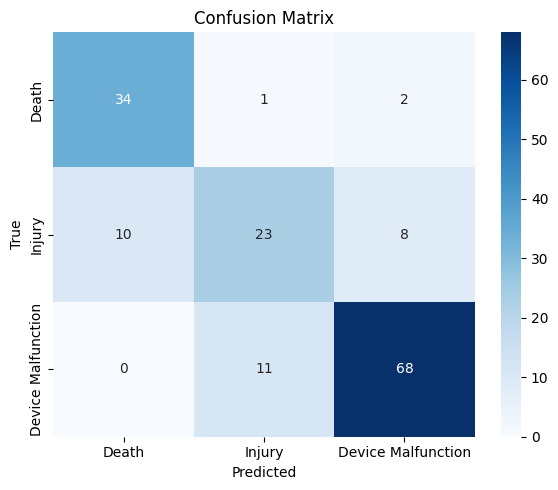

In [38]:
# Accuracy
df=pd.read_csv("testing_2009_data_hybrid.csv",index_col=0)
true_labels=df["output"]
pred_labels=df["predicted_label"]
accuracy = accuracy_score(true_labels, pred_labels)
print(f"Accuracy: {accuracy:.4f}")

# Classification report
print("\nClassification Report:\n")
print(classification_report(true_labels, pred_labels, digits=4))

# Confusion Matrix
labels = ["Death", "Injury", "Device Malfunction"]
cm = confusion_matrix(true_labels, pred_labels, labels=labels)

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=labels, yticklabels=labels, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


Accuracy: 0.8025

Classification Report:

                    precision    recall  f1-score   support

             Death     0.9167    0.8919    0.9041        37
Device Malfunction     0.8955    0.7595    0.8219        79
            Injury     0.6111    0.8049    0.6947        41

          accuracy                         0.8025       157
         macro avg     0.8078    0.8188    0.8069       157
      weighted avg     0.8262    0.8025    0.8081       157



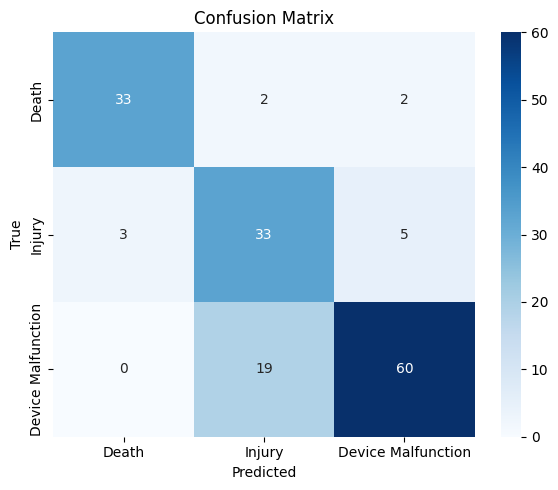

In [39]:
# Accuracy
df=pd.read_csv("testing_2009_data_hybrid.csv",index_col=0)
true_labels=df["output"]
pred_labels=df["final_label"]
accuracy = accuracy_score(true_labels, pred_labels)
print(f"Accuracy: {accuracy:.4f}")

# Classification report
print("\nClassification Report:\n")
print(classification_report(true_labels, pred_labels, digits=4))

# Confusion Matrix
labels = ["Death", "Injury", "Device Malfunction"]
cm = confusion_matrix(true_labels, pred_labels, labels=labels)

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=labels, yticklabels=labels, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


In [3]:
import re, json, numpy as np, pandas as pd
from sentence_transformers import util

# ------------------- Config -------------------
LABELS = ["Death", "Injury", "Device Malfunction"]

# thresholds (tune on your val set)
HI_THRESH = 0.70
MARGIN_THRESH = 0.10
ALPHA_DEFAULT = 0.60    # normal hybrid
ALPHA_LOW = 0.35        # when margin small / confidence low

EVIDENCE_TOPK = 12
EVIDENCE_MIN_COS = 0.30

# Death-specific safeguards
ENFORCE_DEATH_CONFIRMATION = True
DEATH_EVID_MIN = 0.55
DEATH_COS_MIN = 0.58
EVIDENCE_CAP_NO_STRICT_DEATH = 0.35

# Strict death cues
DEATH_STRICT = [
    r"\bpatient (?:died|expired)\b", r"\bpronounced dead\b", r"\bdeclared dead\b",
    r"\bfound deceased\b", r"\bpassed away\b",
    r"\bfatal (?:event|outcome|complication)\b",
    r"\bdeath (?:occurred|reported|confirmed)\b",
    r"\bmortality\b", r"\bfatality\b"
]
NEGATION_PAT = r"(no|not|without|never|denies?|rule[sd]?\s*out)\s+(?:any\s+)?(death|died|deceased|fatal|expired)"

# ------------------- Helpers -------------------
def keybert_terms(text, top_k=15):
    kws = kw_model.extract_keywords(
        text, keyphrase_ngram_range=(1,3), stop_words='english', top_n=top_k
    )
    return [w for w,_ in kws]

def has_strict_death(text: str) -> bool:
    if re.search(NEGATION_PAT, text, flags=re.I):
        return False
    return any(re.search(pat, text, flags=re.I) for pat in DEATH_STRICT)

def parse_prob_dict(x):
    if isinstance(x, dict): 
        return x
    if isinstance(x, str):
        try:
            return json.loads(x.replace("'", '"'))
        except Exception:
            return {}
    return {}

def evidence_for_label(text, label):
    if label not in DICT_TERMS:
        return 0.0, []

    ext_terms = keybert_terms(text, top_k=EVIDENCE_TOPK)
    if not ext_terms:
        return 0.0, []

    dict_terms = DICT_TERMS[label]
    dict_emb = bert_model.encode(dict_terms, convert_to_tensor=True, normalize_embeddings=True)
    ext_emb  = bert_model.encode(ext_terms,  convert_to_tensor=True, normalize_embeddings=True)

    cos = util.cos_sim(ext_emb, dict_emb).cpu().numpy()

    matches = []
    min_cos = DEATH_COS_MIN if label == "Death" else EVIDENCE_MIN_COS

    for i, term in enumerate(ext_terms):
        j = int(cos[i].argmax())
        s = float(cos[i][j])
        if s >= min_cos:
            matches.append({
                "extracted_term": term,
                "matched_dict_term": dict_terms[j],
                "score": round(s, 3)
            })

    if not matches:
        if label == "Death" and has_strict_death(text):
            return 0.9, []
        return 0.0, []

    top_scores = sorted([m["score"] for m in matches], reverse=True)[:5]
    evid = float(np.mean(top_scores))

    if label == "Death":
        if has_strict_death(text):
            evid = max(evid, 0.9)
        else:
            evid = min(evid, EVIDENCE_CAP_NO_STRICT_DEATH)

    return evid, sorted(matches, key=lambda x: x["score"], reverse=True)[:5]

def clean_keyword_list(matches, topn=8, with_scores=False):
    seen, cleaned = set(), []
    for m in sorted(matches, key=lambda x: x["score"], reverse=True):
        term = m["matched_dict_term"]
        if term in seen:
            continue
        seen.add(term)
        if with_scores:
            cleaned.append(f"{term}:{m['score']}")
        else:
            cleaned.append(term)
        if len(cleaned) >= topn:
            break
    return cleaned

def pick_final_with_death_guard(text, combined, evidence):
    cand = max(combined.items(), key=lambda x: x[1])[0]
    if not ENFORCE_DEATH_CONFIRMATION or cand != "Death":
        return cand, "hybrid_fallback"
    strict = has_strict_death(text)
    evid_ok = evidence.get("Death", 0.0) >= DEATH_EVID_MIN
    if strict and evid_ok:
        return "Death", "hybrid_fallback_confirmed_death"
    non_death = {k: v for k, v in combined.items() if k != "Death"}
    alt = max(non_death.items(), key=lambda x: x[1])[0]
    return alt, "death_demoted_insufficient_evidence"

# ------------------- Core classify -------------------
def classify_row(row):
    text = row["input"]
    prob = parse_prob_dict(row["predicted_probability"])
    prob = {lab: float(prob.get(lab, 0.0)) for lab in LABELS}

    sorted_labs = sorted(LABELS, key=lambda l: prob[l], reverse=True)
    top1, top2 = sorted_labs[0], sorted_labs[1]
    p1, p2 = prob[top1], prob[top2]
    margin = p1 - p2

    high_conf_and_clear = (p1 >= HI_THRESH) and (margin > MARGIN_THRESH)
    labels_to_extract = [top1] if high_conf_and_clear else LABELS

    evidence = {lab: 0.0 for lab in LABELS}
    matches  = {lab: []  for lab in LABELS}
    for lab in labels_to_extract:
        e, m = evidence_for_label(text, lab)
        evidence[lab], matches[lab] = e, m

    if high_conf_and_clear:
        final_label = top1
        final_score = p1
        decision = "model_confident"
    else:
        alpha = ALPHA_LOW if margin <= MARGIN_THRESH else ALPHA_DEFAULT
        combined = {lab: alpha*prob[lab] + (1-alpha)*evidence[lab] for lab in LABELS}
        final_label, decision = pick_final_with_death_guard(text, combined, evidence)
        final_score = round(combined[final_label], 3)

    flat_matches = {f"{lab.lower().replace(' ', '_')}_matches": json.dumps(matches[lab], ensure_ascii=False) for lab in LABELS}

    clean_cols = {}
    for lab in LABELS:
        terms_only = clean_keyword_list(matches.get(lab, []), topn=8, with_scores=False)
        terms_with_scores = clean_keyword_list(matches.get(lab, []), topn=8, with_scores=True)
        clean_cols[f"{lab.lower().replace(' ', '_')}_keywords"] = "; ".join(terms_only)
        clean_cols[f"{lab.lower().replace(' ', '_')}_keywords_scored"] = "; ".join(terms_with_scores)

    return {
        "final_label": final_label,
        "final_score": final_score,
        "decision": decision,
        "p_model": json.dumps({lab: round(prob[lab],3) for lab in LABELS}),
        "evidence": json.dumps({lab: round(evidence[lab],3) for lab in LABELS}),
        **flat_matches,
        **clean_cols
    }

# ------------------- Run on CSV -------------------
df = pd.read_csv("testing_2009_data.csv")
hyb = df.apply(classify_row, axis=1)

for col in hyb.iloc[0].keys():
    df[col] = hyb.apply(lambda x: x[col])

df.to_csv("testing_2009_data_hybrid.csv", index=False)
print("✅ Saved: testing_2009_data_hybrid.csv")


✅ Saved: testing_2009_data_hybrid.csv
